Bike_Prediction for Trained dataset

In [3]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import pickle
import numpy as np

# 1. LOAD RESOURCES (Ensure these exist from previous steps)
# ==========================================================
try:
    with open('scaler.pkl', 'rb') as f:
        loaded_scaler = pickle.load(f)
    
    models_to_test = {}
    model_names = ['ridge_regression', 'lasso_regression', 
                   'decision_tree_regression', 'random_forest_regression']
    
    for name in model_names:
        with open(f"{name}_model.pkl", 'rb') as f:
            # Create readable name (e.g., "Ridge Regression")
            clean_name = name.replace('_', ' ').title()
            models_to_test[clean_name] = pickle.load(f)

except FileNotFoundError:
    print("⚠️ Error: Model or Scaler files not found. Please run the training cells above first.")

# 2. CREATE WIDGETS
# ==========================================================
style = {'description_width': 'initial'}

# Time & Date Widgets
season_w = widgets.Dropdown(options=[('Spring', 1), ('Summer', 2), ('Fall', 3), ('Winter', 4)],
                            value=2, description='Season:', style=style)
year_w = widgets.Dropdown(options=[('2011', 0), ('2012', 1)],
                          value=1, description='Year:', style=style)
month_w = widgets.IntSlider(min=1, max=12, value=6, description='Month:', style=style)
weekday_w = widgets.Dropdown(options=[('Sunday', 0), ('Monday', 1), ('Tuesday', 2), ('Wednesday', 3), 
                                      ('Thursday', 4), ('Friday', 5), ('Saturday', 6)],
                             value=1, description='Day of Week:', style=style)
holiday_w = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='Is Holiday?', style=style)
workingday_w = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=1, description='Is Working Day?', style=style)
weekend_w = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='Is Weekend?', style=style)

# Weather Widgets
weather_w = widgets.Dropdown(options=[('Clear/Cloudy', 1), ('Mist/Cloudy', 2), ('Light Rain/Snow', 3), ('Heavy Rain/Snow', 4)],
                             value=1, description='Weather:', style=style)
temp_w = widgets.FloatSlider(min=-10.0, max=40.0, value=25.0, step=0.5, description='Temp (°C):', style=style)
hum_w = widgets.FloatSlider(min=0.0, max=100.0, value=50.0, step=1.0, description='Humidity (%):', style=style)
wind_w = widgets.FloatSlider(min=0.0, max=60.0, value=10.0, step=0.5, description='Windspeed:', style=style)

# Button & Output
btn_predict = widgets.Button(description="Predict Bike Rentals", button_style='success', icon='bicycle')
output = widgets.Output()

# 3. PREDICTION LOGIC
# ==========================================================
def on_predict_click(b):
    with output:
        output.clear_output()
        
        # Create dataframe from widget values
        # CRITICAL: Columns must be in exact order of X_train
        input_data = {
            'season': [season_w.value],
            'yr': [year_w.value],
            'mnth': [month_w.value],
            'holiday': [holiday_w.value],
            'weekday': [weekday_w.value],
            'workingday': [workingday_w.value],
            'weathersit': [weather_w.value],
            'temp': [temp_w.value],
            'hum': [hum_w.value],
            'windspeed': [wind_w.value],
            'is_weekend': [weekend_w.value]
        }
        
        df_input = pd.DataFrame(input_data)
        
        # Scale
        try:
            df_scaled = loaded_scaler.transform(df_input)
            
            print(f"--- Prediction Results for Selected Input ---\n")
            
            results = []
            for name, model in models_to_test.items():
                pred = int(model.predict(df_scaled)[0])
                results.append({'Model': name, 'Predicted Rentals': pred})
            
            # Display pretty table
            res_df = pd.DataFrame(results)
            display(res_df.style.hide(axis='index').background_gradient(cmap='Greens'))
            
        except Exception as e:
            print(f"Error during prediction: {e}")

btn_predict.on_click(on_predict_click)

# 4. DISPLAY DASHBOARD
# ==========================================================
ui = widgets.VBox([
    widgets.HTML("<h3>🚲 Bike Sharing Demand Predictor</h3>"),
    widgets.HBox([season_w, year_w, month_w]),
    widgets.HBox([weekday_w, holiday_w, workingday_w, weekend_w]),
    widgets.HTML("<hr>"),
    widgets.HBox([weather_w, temp_w]),
    widgets.HBox([hum_w, wind_w]),
    widgets.HTML("<br>"),
    btn_predict,
    output
])

display(ui)

Model_Comapariosn for Seen Data and Unseen Data

--- 1. Loading Resources ---
Loaded scaler and training performance summary.
Loaded unseen data: (730, 16)

--- 2. Preprocessing Unseen Data ---

--- 3. Evaluating Models on Unseen Data ---

--- Performance Comparison (R-Squared) ---
           Model   Seen_R2  Unseen_R2
0          Ridge  0.846011   0.799015
1          Lasso  0.846108   0.799032
2  Decision Tree  0.864342   0.975189
3  Random Forest  0.909360   0.969151

Comparison plot saved as 'seen_vs_unseen_comparison.png'


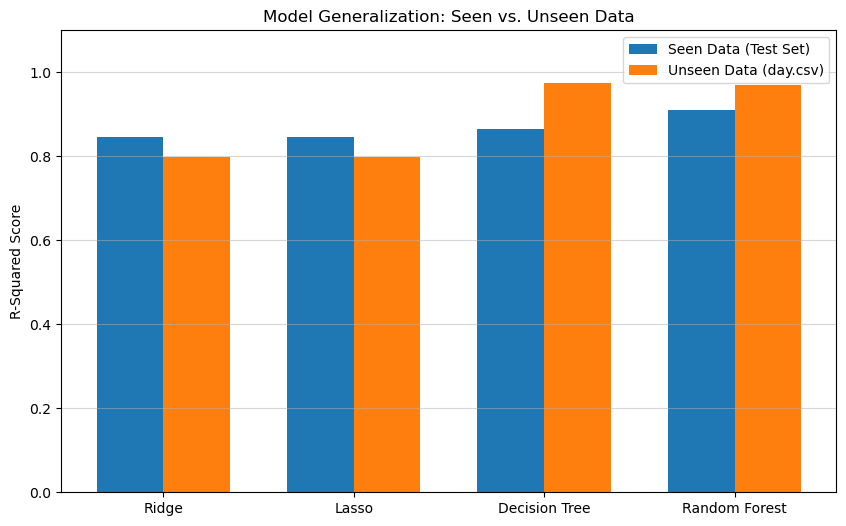

Predictions saved to 'final_predictions_unseen.csv'


In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Configuration ---
UNSEEN_DATA_PATH = r"C:\Users\preet\Downloads\day.csv"  # Your new file
SUMMARY_PATH = 'model_performance_summary.csv'          # From training step
SCALER_PATH = 'scaler.pkl'
MODEL_PATHS = {
    'Ridge': 'ridge_regression_model.pkl',
    'Lasso': 'lasso_regression_model.pkl',
    'Decision Tree': 'decision_tree_regression_model.pkl',
    'Random Forest': 'random_forest_regression_model.pkl'
}
FEATURE_COLS = [
    'season', 'yr', 'mnth', 'holiday', 'weekday', 
    'workingday', 'weathersit', 'temp', 'hum', 
    'windspeed', 'is_weekend'
]

def test_and_compare():
    print("--- 1. Loading Resources ---")
    try:
        # Load Scaler
        with open(SCALER_PATH, 'rb') as f:
            scaler = pickle.load(f)
        
        # Load Previous Performance (Seen Data)
        seen_metrics = pd.read_csv(SUMMARY_PATH, index_col=0)
        print("Loaded scaler and training performance summary.")
        
        # Load Unseen Data
        df_unseen = pd.read_csv(UNSEEN_DATA_PATH)
        print(f"Loaded unseen data: {df_unseen.shape}")
        
    except FileNotFoundError as e:
        print(f"Critical Error: {e}")
        print("Ensure all .pkl files and .csv files are in the current directory.")
        return

    print("\n--- 2. Preprocessing Unseen Data ---")
    # Create 'is_weekend' if missing
    if 'is_weekend' not in df_unseen.columns:
        df_unseen['is_weekend'] = df_unseen['weekday'].apply(lambda x: 1 if x == 0 or x == 6 else 0)

    # Handle Unit Conversion (Normalized -> Raw)
    # Your model was trained on raw values (e.g., temp=14), but day.csv is often 0-1.
    if df_unseen['temp'].max() <= 1.5:
        print("  > Detected normalized units. Converting to original scale...")
        df_unseen['temp'] = df_unseen['temp'] * 41
        df_unseen['hum'] = df_unseen['hum'] * 100
        df_unseen['windspeed'] = df_unseen['windspeed'] * 67

    # Select and Scale Features
    try:
        X_unseen = df_unseen[FEATURE_COLS]
        X_unseen_scaled = scaler.transform(X_unseen)
    except KeyError as e:
        print(f"Error: Unseen dataset is missing columns: {e}")
        return

    print("\n--- 3. Evaluating Models on Unseen Data ---")
    
    comparison_data = []
    predictions_df = df_unseen.copy()

    for name, path in MODEL_PATHS.items():
        try:
            # Load Model
            with open(path, 'rb') as f:
                model = pickle.load(f)
            
            # Predict
            preds = model.predict(X_unseen_scaled)
            predictions_df[f'Pred_{name}'] = preds
            
            # Calculate Metrics (Unseen)
            if 'cnt' in df_unseen.columns:
                actual = df_unseen['cnt']
                r2_unseen = r2_score(actual, preds)
                rmse_unseen = np.sqrt(mean_squared_error(actual, preds))
                
                # Get metrics for Seen Data (from summary file)
                r2_seen = seen_metrics.loc[f"{name} Regression", 'R-squared'] if f"{name} Regression" in seen_metrics.index else 0
                
                comparison_data.append({
                    'Model': name,
                    'Seen_R2': r2_seen,
                    'Unseen_R2': r2_unseen,
                    'Unseen_RMSE': rmse_unseen
                })
                
        except Exception as e:
            print(f"Could not evaluate {name}: {e}")

    # --- 4. Comparison & Visualization ---
    if comparison_data:
        comp_df = pd.DataFrame(comparison_data)
        print("\n--- Performance Comparison (R-Squared) ---")
        print(comp_df[['Model', 'Seen_R2', 'Unseen_R2']])
        
        # Plotting
        plt.figure(figsize=(10, 6))
        x = np.arange(len(comp_df['Model']))
        width = 0.35
        
        plt.bar(x - width/2, comp_df['Seen_R2'], width, label='Seen Data (Test Set)')
        plt.bar(x + width/2, comp_df['Unseen_R2'], width, label='Unseen Data (day.csv)')
        
        plt.ylabel('R-Squared Score')
        plt.title('Model Generalization: Seen vs. Unseen Data')
        plt.xticks(x, comp_df['Model'])
        plt.ylim(0, 1.1)
        plt.legend()
        plt.grid(axis='y', alpha=0.5)
        
        plt.savefig('seen_vs_unseen_comparison.png')
        print("\nComparison plot saved as 'seen_vs_unseen_comparison.png'")
        plt.show()

        # Save Predictions
        predictions_df.to_csv('final_predictions_unseen.csv', index=False)
        print("Predictions saved to 'final_predictions_unseen.csv'")

if __name__ == "__main__":
    test_and_compare()

Bike Prediction for Unseen data

In [2]:
import pandas as pd
import pickle
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==========================================
# CONFIGURATION & PATHS
# ==========================================
# Path to the training data (used only if Linear Regression needs to be retrained)
TRAINING_DATA_PATH = r"C:\Users\preet\Downloads\day.csv"

SCALER_PATH = 'scaler.pkl'

# Dictionary of all models to be used
MODELS_CONFIG = {
    'Linear Regression': 'linear_regression_model.pkl',
    'Random Forest': 'random_forest_regression_model.pkl',
    'Decision Tree': 'decision_tree_regression_model.pkl',
    'Ridge': 'ridge_regression_model.pkl',
    'Lasso': 'lasso_regression_model.pkl'
}

# Exact feature order expected by the models
FEATURE_COLS = [
    'season', 'yr', 'mnth', 'holiday', 'weekday', 
    'workingday', 'weathersit', 'temp', 'hum', 
    'windspeed', 'is_weekend'
]

# ==========================================
# PART 1: TRAINING LOGIC
# ==========================================
def ensure_linear_regression_model():
    """
    Checks if the Linear Regression model exists. 
    If not, it loads the data, trains the model, and saves it.
    """
    lr_model_path = MODELS_CONFIG['Linear Regression']
    
    if os.path.exists(lr_model_path):
        print(f"[INFO] Found existing {lr_model_path}. Skipping training.")
        return

    print(f"[WARN] {lr_model_path} not found. Initializing training sequence...")
    
    try:
        # 1. Load Data
        if not os.path.exists(TRAINING_DATA_PATH):
            print(f"[CRITICAL ERROR] Training data not found at: {TRAINING_DATA_PATH}")
            print("Cannot train Linear Regression. Prediction will proceed without it.")
            return

        data = pd.read_excel(TRAINING_DATA_PATH)
        X = data.drop('cnt', axis=1)
        y = data['cnt']
        
        # 2. Split Data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # 3. Handle Scaler
        if os.path.exists(SCALER_PATH):
            with open(SCALER_PATH, 'rb') as f:
                scaler = pickle.load(f)
            print("  > Using existing scaler.")
        else:
            print("  > Scaler not found. Fitting a new one.")
            scaler = StandardScaler()
            scaler.fit(X_train)
            with open(SCALER_PATH, 'wb') as f:
                pickle.dump(scaler, f)
        
        X_train_scaled = scaler.transform(X_train)
        
        # 4. Train Model
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_scaled, y_train)
        
        # 5. Save Model
        with open(lr_model_path, 'wb') as f:
            pickle.dump(lin_reg, f)
            
        print(f"[SUCCESS] Trained and saved {lr_model_path}")
        
    except Exception as e:
        print(f"[ERROR] Failed during Linear Regression training: {e}")

# ==========================================
# PART 2: LOADING ARTIFACTS
# ==========================================
def load_artifacts():
    """Loads the scaler and all available model files."""
    loaded_models = {}
    scaler = None
    
    try:
        with open(SCALER_PATH, 'rb') as f:
            scaler = pickle.load(f)
        print(f"[OK] Loaded {SCALER_PATH}")
    except FileNotFoundError:
        print(f"[ERROR] Critical: {SCALER_PATH} is missing.")
        return None, None

    print("--- Loading Models ---")
    for name, path in MODELS_CONFIG.items():
        try:
            with open(path, 'rb') as f:
                loaded_models[name] = pickle.load(f)
            print(f"  [OK] {name}")
        except FileNotFoundError:
            print(f"  [SKIP] {name} (File not found)")
    
    return scaler, loaded_models

# ==========================================
# PART 3: USER INTERFACE (CORRECTED)
# ==========================================
def get_user_input():
    """Prompts user for input and handles normalization logic automatically."""
    print("\n" + "-"*40)
    print(" ENTER PREDICTION DETAILS")
    print("-" * 40)
    
    data = {}
    try:
        # --- Categorical Inputs ---
        data['season'] = int(input("Season (1:Winter, 2:Spring, 3:Summer, 4:Fall): "))
        
        # FIX: Handle Year Input safely
        raw_yr = int(input("Year (e.g. 2011 or 2012): "))
        if raw_yr == 2011:
            data['yr'] = 0
        elif raw_yr == 2012:
            data['yr'] = 1
        elif raw_yr == 0 or raw_yr == 1:
            data['yr'] = raw_yr # User already entered code
        else:
            print("[WARNING] Unknown year entered. Defaulting to 2012 (1).")
            data['yr'] = 1
        
        data['mnth'] = int(input("Month (1-12): "))
        data['holiday'] = int(input("Holiday (0:No, 1:Yes): "))
        data['weekday'] = int(input("Weekday (0:Sun, 1:Mon... 6:Sat): "))
        data['workingday'] = int(input("Working Day (0:No, 1:Yes): "))
        data['weathersit'] = int(input("Weather (1:Clear, 2:Mist, 3:Snow/Rain): "))
        
        # --- Numerical Inputs ---
        data['temp'] = float(input("Temperature (Celsius): "))
        data['hum'] = float(input("Humidity (0-100): "))
        data['windspeed'] = float(input("Windspeed: "))
        
        # Logic for 'is_weekend'
        if data['weekday'] == 0 or data['weekday'] == 6:
            data['is_weekend'] = 1
        else:
            data['is_weekend'] = 0
            
    except ValueError:
        print("\n[ERROR] Invalid input! Please enter numbers only.")
        return None

    # Return as DataFrame
    return pd.DataFrame([data], columns=FEATURE_COLS)

# ==========================================
# MAIN EXECUTION FLOW
# ==========================================
def main():
    print("=== BIKE SHARE DEMAND PREDICTOR SYSTEM ===")
    ensure_linear_regression_model()
    
    print("\n=== INITIALIZATION ===")
    scaler, models = load_artifacts()
    
    if not scaler or not models:
        print("Critical Error: Missing scaler or no models loaded. Exiting.")
        return

    # Prediction Loop
    while True:
        input_df = get_user_input()
        
        if input_df is not None:
            # Scale the input using the same scaler as training
            input_scaled = scaler.transform(input_df)
            
            print("\n" + "="*40)
            print(" PREDICTED BIKE DEMAND COUNT")
            print("="*40)
            
            for name, model in models.items():
                try:
                    pred = model.predict(input_scaled)[0]
                    # Ensuring prediction isn't negative (models can sometimes do this)
                    final_pred = max(0, int(pred))
                    print(f"{name.ljust(25)}: {final_pred} bikes")
                except Exception as e:
                    print(f"{name.ljust(25)}: Error ({e})")
            
            print("="*40)
        
        cont = input("\nTest another datapoint? (y/n): ")
        if cont.lower() != 'y':
            print("Exiting...")
            break

if __name__ == "__main__":
    main()

=== BIKE SHARE DEMAND PREDICTOR SYSTEM ===
[INFO] Found existing linear_regression_model.pkl. Skipping training.

=== INITIALIZATION ===
[OK] Loaded scaler.pkl
--- Loading Models ---
  [OK] Linear Regression
  [OK] Random Forest
  [OK] Decision Tree
  [OK] Ridge
  [OK] Lasso

----------------------------------------
 ENTER PREDICTION DETAILS
----------------------------------------


Season (1:Winter, 2:Spring, 3:Summer, 4:Fall):  3
Year (e.g. 2011 or 2012):  2011
Month (1-12):  5
Holiday (0:No, 1:Yes):  0
Weekday (0:Sun, 1:Mon... 6:Sat):  4
Working Day (0:No, 1:Yes):  1
Weather (1:Clear, 2:Mist, 3:Snow/Rain):  1
Temperature (Celsius):  30
Humidity (0-100):  50
Windspeed:  30



 PREDICTED BIKE DEMAND COUNT
Linear Regression        : 4837 bikes
Random Forest            : 4429 bikes
Decision Tree            : 5225 bikes
Ridge                    : 4834 bikes
Lasso                    : 4834 bikes



Test another datapoint? (y/n):  y



----------------------------------------
 ENTER PREDICTION DETAILS
----------------------------------------


Season (1:Winter, 2:Spring, 3:Summer, 4:Fall):  1
Year (e.g. 2011 or 2012):  2012
Month (1-12):  12
Holiday (0:No, 1:Yes):  0
Weekday (0:Sun, 1:Mon... 6:Sat):  2
Working Day (0:No, 1:Yes):  1
Weather (1:Clear, 2:Mist, 3:Snow/Rain):  3
Temperature (Celsius):  20
Humidity (0-100):  25
Windspeed:  34



 PREDICTED BIKE DEMAND COUNT
Linear Regression        : 2788 bikes
Random Forest            : 5747 bikes
Decision Tree            : 5585 bikes
Ridge                    : 2801 bikes
Lasso                    : 2809 bikes



Test another datapoint? (y/n):  n


Exiting...
